In [236]:
%matplotlib inline

In [237]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as pp

# Generating Data

In [238]:
N = 100000

household_income = np.random.gamma(50, 1000, size=N)  # Z1, in USD. probably unrealistic, 
                                                      # since not long-tailed enough
parents_education = np.random.choice(range(5), size=N)  # Z2, labels ['no high school', high school', 'some college', 'BA/BS', 
                                                        #             'post-grad degree']
last_year_gpa = np.random.uniform(2.0, 4.0, size=N)  # Z3 on a 4-point scale, 
                                                     # assuming everyone passed last year
commute_time = np.random.gamma(1, 1, size=N)  # Z4, in hours
hobby_engagement = np.random.gamma(2, 1, size=N) # Z5, in hours per week

df = pd.DataFrame({'household_income': household_income,
                   'parents_education': parents_education,
                   'last_year_gpa': last_year_gpa,
                   'commute_time': commute_time,
                   'hobby_engagement': hobby_engagement})


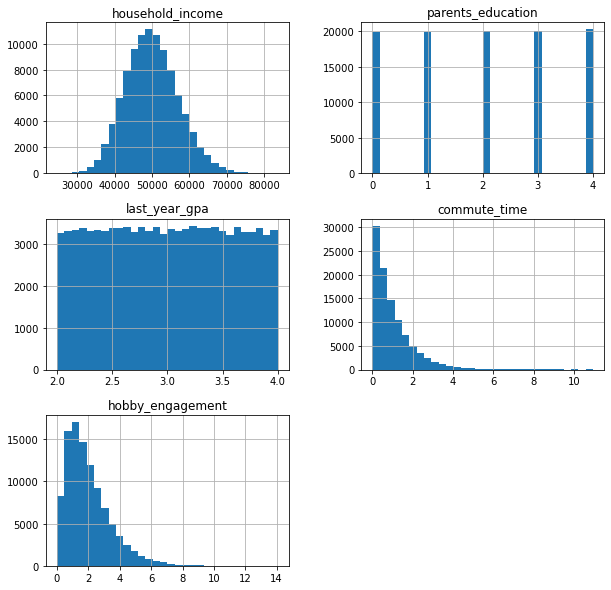

In [239]:
df.hist(figsize=(10,10), bins=30);

In [240]:
beta_ca = 1.
beta_ha = -1.
beta_ia = 1.
beta_ga = -1.
beta_ea = 1.
beta_a = -3

phi = beta_ca * df['commute_time'] / df['commute_time'].std() + \
      beta_ha * df['hobby_engagement'] / df['hobby_engagement'].std()+ \
      beta_ia * df['household_income'] / df['household_income'].std()+ \
      beta_ga * df['last_year_gpa'] / df['last_year_gpa'].std() + \
      beta_ea * df['parents_education'] / df['parents_education'].std() + \
      beta_a
p_app = 1. / (1. + np.exp(-phi))
df['uses_app'] = np.random.binomial(1., p=p_app)

In [241]:
df.mean()

household_income     49978.050187
parents_education        2.009510
last_year_gpa            2.999310
commute_time             1.000307
hobby_engagement         2.007624
uses_app                 0.482310
dtype: float64

In [242]:
df.corr()

,household_income,parents_education,last_year_gpa,commute_time,hobby_engagement,uses_app
household_income,1.000000,-0.000042,-0.003146,0.002336,0.002089,0.283521
parents_education,-0.000042,1.000000,-0.001203,-0.002486,-0.000333,0.292471
last_year_gpa,-0.003146,-0.001203,1.000000,-0.000747,0.003226,-0.294910
commute_time,0.002336,-0.002486,-0.000747,1.000000,-0.002351,0.263965
hobby_engagement,0.002089,-0.000333,0.003226,-0.002351,1.000000,-0.265660
uses_app,0.283521,0.292471,-0.294910,0.263965,-0.265660,1.000000


In [243]:
beta_cp = -1.
beta_hp = -1.
beta_ip = 1.
beta_gp = 8.
beta_p = -50
beta_ep = 1.

delta = 0.1

phi_p = beta_cp * df['commute_time'] / df['commute_time'].std() + \
        beta_hp * df['hobby_engagement'] / df['hobby_engagement'].std()+ \
        beta_ip * df['household_income'] / df['household_income'].std()+ \
        beta_gp * df['last_year_gpa'] / df['last_year_gpa'].std() + \
        beta_ep * df['parents_education'] / df['parents_education'].std() + \
        beta_p
p_passes = np.minimum(1. / (1. + np.exp(-phi_p/5)), 1. - delta - 0.001) + df['uses_app']*delta
df['passes'] = np.random.binomial(1., p=p_passes)

<AxesSubplot:>

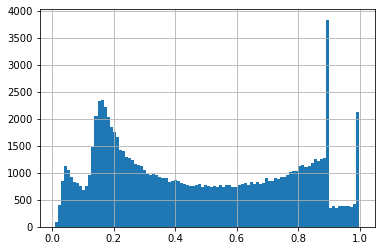

In [244]:
p_passes.hist(bins=100)

In [245]:
df.mean()

household_income     49978.050187
parents_education        2.009510
last_year_gpa            2.999310
commute_time             1.000307
hobby_engagement         2.007624
uses_app                 0.482310
passes                   0.479100
dtype: float64

In [246]:
df.corr()

,household_income,parents_education,last_year_gpa,commute_time,hobby_engagement,uses_app,passes
household_income,1.000000,-0.000042,-0.003146,0.002336,0.002089,0.283521,0.089315
parents_education,-0.000042,1.000000,-0.001203,-0.002486,-0.000333,0.292471,0.085072
last_year_gpa,-0.003146,-0.001203,1.000000,-0.000747,0.003226,-0.294910,0.542995
commute_time,0.002336,-0.002486,-0.000747,1.000000,-0.002351,0.263965,-0.037276
hobby_engagement,0.002089,-0.000333,0.003226,-0.002351,1.000000,-0.265660,-0.082918
uses_app,0.283521,0.292471,-0.294910,0.263965,-0.265660,1.000000,-0.035192
passes,0.089315,0.085072,0.542995,-0.037276,-0.082918,-0.035192,1.000000


In [247]:
## Let's check the naive estimate

df.groupby('uses_app').mean()['passes'][1] - df.groupby('uses_app').mean()['passes'][0]

-0.03518292402812784

Looks like the effect is biased, from its true value of 0.1 percentage points.

Now, let's try exact matching. First, we should pre-process our continuous variables into discrete variables.

# Exact Matching

Let's discretize with quantile discretization

In [248]:
continuous_variables = ['household_income',
                        'last_year_gpa',
                        'commute_time',
                        'hobby_engagement']
number_of_strata = 5
for variable in continuous_variables:
    df['{}_discrete'.format(variable)] = pd.qcut(df['{}'.format(variable)], 
                                                 number_of_strata, 
                                                 labels=range(number_of_strata)).astype(int)

In [249]:
df.head()

,household_income,parents_education,last_year_gpa,commute_time,hobby_engagement,uses_app,passes,household_income_discrete,last_year_gpa_discrete,commute_time_discrete,hobby_engagement_discrete
0,61904.740709,0,3.383905,0.051271,0.127383,1,1,4,3,0,0
1,47082.806558,1,3.447803,4.746682,1.206258,1,0,1,3,4,1
2,55752.881208,0,3.590264,0.240381,5.432306,0,1,3,3,1,4
3,40119.451438,4,3.035910,0.358731,2.443943,1,1,0,2,1,3
4,43874.212138,0,2.677438,0.696017,0.688548,0,0,0,1,2,0


In [250]:
# how much data per x-z stratum?

N / (2. * np.power(5,5))

16.0

In [251]:
df.columns

Index(['household_income', 'parents_education', 'last_year_gpa',
       'commute_time', 'hobby_engagement', 'uses_app', 'passes',
       'household_income_discrete', 'last_year_gpa_discrete',
       'commute_time_discrete', 'hobby_engagement_discrete'],
      dtype='object')

In [252]:
processed_variables = ['uses_app', 'passes', 'household_income_discrete', 'last_year_gpa_discrete', 
                       'commute_time_discrete', 'hobby_engagement_discrete','parents_education']
matching_variables = ['household_income_discrete', 'last_year_gpa_discrete', 
                       'commute_time_discrete', 'hobby_engagement_discrete','parents_education']

In order to do matching, we need each matching stratum, $Z$, to contain both a person who uses the app and one who doesn't, so we can compare them. Here, the strata are defined by having the same values for each of the matching variables. If we groupby the matching variables and count the number of people in each group, we'll see whether this is a feasible approach.

**Question**: What if we're missing people in some strata? How much missingness can we get away with?

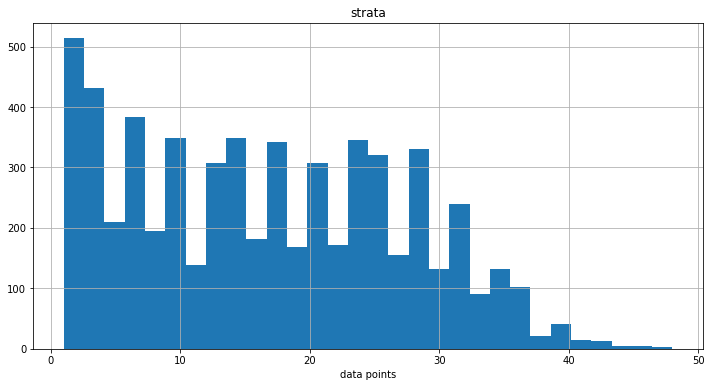

In [253]:
df.groupby(matching_variables + ['uses_app']).count()\
                                             .rename(columns={'passes': 'strata'})\
                                             .hist('strata', bins=30, figsize=(12,6)); 
pp.xlabel(xlabel='data points');

So we see most strata have enough people in them to suspect we'll get good matches. If we were concerned about the loss of data, we could instead change the bin count to a lower number. For example, if instead of 5 bins per $Z$ variable, which gives us $5^5 = 3125$ different $Z$ strata, we tried only 2 bins per variable, we'd have only $2^5 = 32$ different $Z$ strata.



In [198]:
continuous_variables = ['household_income',
                        'last_year_gpa',
                        'commute_time',
                        'hobby_engagement']
number_of_bins = 2
for variable in continuous_variables:
    df['{}_discrete'.format(variable)] = pd.qcut(df['{}'.format(variable)], 
                                                 number_of_bins, 
                                                 labels=range(number_of_bins)).astype(int)

In [199]:
# And now we'll coarsen education to high school and lower vs greater than high school

df['parents_education_coarse'] = df['parents_education'].apply(lambda x: x > 1).astype(int)

In [200]:
processed_variables = ['uses_app', 'passes', 'household_income_discrete', 'last_year_gpa_discrete', 
                       'commute_time_discrete', 'hobby_engagement_discrete','parents_education']
matching_variables = ['household_income_discrete', 'last_year_gpa_discrete', 
                       'commute_time_discrete', 'hobby_engagement_discrete','parents_education_coarse']

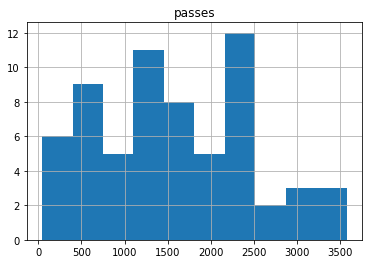

In [201]:
df.groupby(matching_variables + ['uses_app']).count().hist('passes');

In [202]:
len(df.groupby(matching_variables + ['uses_app']).count())

64

This loses quite a lot of information. You can play with the parameters here (rerunning from the beginning each time) to get a feel for how much the effect estimates below change when you vary the discretization.

# Performing Matching

In [254]:
index_variables = matching_variables + ['uses_app']


In [255]:
z_strata = df.groupby(index_variables)

def choose_match(row):
    index = row[index_variables].copy()
    index['uses_app'] = 1 - index['uses_app']
    try:
        matches = z_strata.get_group(tuple(index[index_variables].values))
    except:
        return np.nan
    match = matches.sample(n=1)
    return match['passes'].values[0]

df['matched_outcome'] = df.apply(choose_match, axis=1)

In [256]:
df.mean()

household_income             49978.050187
parents_education                2.009510
last_year_gpa                    2.999310
commute_time                     1.000307
hobby_engagement                 2.007624
uses_app                         0.482310
passes                           0.479100
household_income_discrete        2.000000
last_year_gpa_discrete           2.000000
commute_time_discrete            2.000000
hobby_engagement_discrete        2.000000
matched_outcome                  0.478534
dtype: float64

In [257]:
y1 = df['uses_app']*df['passes'] + (1. - df['uses_app'])*df['matched_outcome']
y0 = (1-df['uses_app'])*df['passes'] + (df['uses_app'])*df['matched_outcome']
(y1 - y0).mean()

0.09662836079791848

In [258]:
att = df.groupby('uses_app').mean()['passes'][1] - df.groupby('uses_app').mean()['matched_outcome'][1]
att

0.08792910999503967

In [259]:
atc = df.groupby('uses_app').mean()['matched_outcome'][0] - df.groupby('uses_app').mean()['passes'][0]
atc

0.08211519433262926

In [260]:
p_x = df.mean()['uses_app']


In [261]:
p_x*att + (1 - p_x) * atc

0.08491930399576643

In [262]:
df.groupby(['passes', 'uses_app', 'matched_outcome']).count().sum() / N

household_income             0.9224
parents_education            0.9224
last_year_gpa                0.9224
commute_time                 0.9224
hobby_engagement             0.9224
household_income_discrete    0.9224
last_year_gpa_discrete       0.9224
commute_time_discrete        0.9224
hobby_engagement_discrete    0.9224
dtype: float64